In [1]:
import geopandas as gpd
# import LasBuildSeg as Lasb
import numpy as np
import os
import laspy
import rasterio
import pyproj
import cv2
import scipy
from scipy.interpolate import griddata
from rasterio.transform import from_origin
import scipy.spatial
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask
import rasterio.features
from shapely.geometry import shape, mapping
import json
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter, minimum_filter


def generate_dsm(las_file_path: str, input_epsg: int, interpolation_method: str):
    """
    Generate a Digital Surface Model (DSM) from a LAS file.

    Args:
        las_file_path (str): Path to the LAS file.
        input_epsg (int): EPSG code of the input coordinate reference system (CRS).
        interpolation_method (str): Interpolation method to use.

    Outputs:
        dsm.tif the output DSM file.
    """
    # Read the LAS file
    las_file = laspy.read(las_file_path)
    resolution = 1

    # Create a Pyproj CRS object for the input EPSG code
    input_crs = pyproj.CRS.from_epsg(input_epsg)
    print("input_crs in generate_dsm ater pyproj.CRS.from_epsg ", input_crs)

    # Extract the x, y, and z coordinates from the LAS file
    x = las_file.x
    y = las_file.y
    z = las_file.z

    # Calculate the grid bounds based on the x and y coordinates
    x_min = np.floor(min(x))
    x_max = np.ceil(max(x))
    y_min = np.floor(min(y))
    y_max = np.ceil(max(y))

    # Generate the grid of points for the DSM
    grid_x, grid_y = np.meshgrid(
        np.arange(x_min, x_max, resolution), np.arange(y_min, y_max, resolution)
    )

    # Generate the DSM using the specified interpolation method
    dsm = griddata((x, y), z, (grid_x, grid_y), method=interpolation_method)


    dsm = minimum_filter(dsm, 3)
    dsm = median_filter(dsm, 3)
    dsm = median_filter(dsm, 3)
    # Save the DSM to a GeoTIFF file using rasterio
    with rasterio.open(
        "dsm.tif",
        "w",
        driver="GTiff",
        height=dsm.shape[0],
        width=dsm.shape[1],
        count=1,
        dtype=dsm.dtype,
        crs=input_crs,
        transform=rasterio.transform.Affine(resolution, 0, x_min, 0, resolution, y_min),
    ) as dst:
        dst.write(dsm, 1)

    # Visualize the result
    plt.figure(figsize=(10, 10))
    plt.imshow(dsm)
    plt.title("DSM")
    plt.axis("on")
    plt.show()

    print("Success in Creating DSM")


def generate_dtm(las_file_path, input_epsg, interpolation_method, ground_multiplier):
    """
    Generate a Digital Terrain Model (DTM) from LiDAR data (This is not a %100 accurate DSM but it enchances
                                                            the resualts of the building extraction.)

    Args:
        las_file_path (str): Path to the LAS file.
        input_epsg (int): EPSG code of the input coordinate reference system.
        interpolation_method (str): Interpolation method for non-ground points.
        ground_multiplier (float): Multiplier for ground values in the DTM for contrast ecnheament.

    Returns:
        dtm.tif the output DSM file
    """

    # Load LiDAR data
    las_data = laspy.read(las_file_path)

    # Set the desired resolution
    resolution = 1

    # Create a Pyproj CRS object for the input EPSG code
    input_crs = pyproj.CRS.from_epsg(input_epsg)

    # Extract x, y, and z coordinates from the LiDAR data
    points = np.vstack((las_data.x, las_data.y, las_data.z)).T

    # Determine the bounds of the point cloud
    min_x, max_x = np.min(points[:, 0]), np.max(points[:, 0])
    min_y, max_y = np.min(points[:, 1]), np.max(points[:, 1])

    # Classify ground points in the LiDAR data (class 2)
    ground_points = points[las_data.classification == 2]

    # Calculate the size of the output raster
    width = int(np.ceil((max_x - min_x) / resolution))
    height = int(np.ceil((max_y - min_y) / resolution))

    # Create the output raster profile
    profile = {
        "driver": "GTiff",
        "height": height,
        "width": width,
        "count": 1,
        "dtype": "float32",
        "crs": input_crs,
        "transform": from_origin(min_x, min_y, resolution, -resolution),
    }

    # Create an empty numpy array for the output DTM
    dtm = np.zeros((height, width), dtype=np.float32)

    # Create a KDTree from the x, y coordinates of the ground points
    ground_tree = scipy.spatial.cKDTree(ground_points[:, :2])

    # Create a mesh grid for the output raster
    mesh_x, mesh_y = np.meshgrid(
        np.arange(min_x, max_x, resolution), np.arange(min_y, max_y, resolution)
    )

    # Interpolate the z values of the ground points onto the mesh grid
    ground_values = ground_tree.query(np.vstack((mesh_x.ravel(), mesh_y.ravel())).T)[0]
    mesh_z = ground_values.reshape(mesh_x.shape)

    # Load the point cloud
    dtm_data = las_data
    dtm_points = np.vstack((dtm_data.x, dtm_data.y, dtm_data.z)).T

    # Classify points as non-ground (not class 2)
    non_ground_points = dtm_points[dtm_data.classification != 2]

    # Interpolate the non-ground points onto the mesh grid
    non_ground_z = griddata(
        non_ground_points[:, :2],
        non_ground_points[:, 2],
        (mesh_x, mesh_y),
        method=interpolation_method,
    )

    # Subtract the interpolated non-ground values from the interpolated ground values also enhancge the contrast by using ground_multiplier
    dtm = ground_multiplier * mesh_z - non_ground_z

    # Write the output raster to a file
    with rasterio.open("dtm.tif", "w", **profile) as dst:
        dst.write(dtm, 1)
    # Visualize the result
    plt.figure(figsize=(10, 10))
    plt.imshow(dtm)
    plt.title("DTM")
    plt.axis("on")
    plt.show()
    print("Success in Creating DTM")


def generate_ndhm(dtm_file, dsm_file):
    """
    Generate the Normalized Digital Height Model (NDHM) by subtracting the Digital Terrain Model (DTM) from the Digital Surface Model (DSM).

    Args:
        dtm_file (str): Path to the DTM file.
        dsm_file (str): Path to the DSM file.

    Returns:
       ndhm.tiff output NDHM file
    """

    # Load DSM and DTM
    with rasterio.open(dsm_file) as dsm_src:
        dsm = dsm_src.read(1)
        dsm_meta = dsm_src.profile

    with rasterio.open(dtm_file) as dtm_src:
        dtm = dtm_src.read(1)

    # Compute NDHM
    ndhm = dsm - dtm

    # Write NDHM to file
    ndhm_meta = dsm_meta.copy()
    ndhm_meta["dtype"] = "float32"
    with rasterio.open("ndhmtemp.tif", "w", **ndhm_meta) as ndhm_dst:
        ndhm_dst.write(ndhm.astype(np.float32), 1)

    # Define the target CRS as EPSG:3857
    target_crs = "EPSG:3857"

    # Open the input file
    with rasterio.open("ndhmtemp.tif") as src:
        # Get the metadata of the input file
        src_profile = src.profile.copy()

        # Calculate the transform to the target CRS
        dst_transform, dst_width, dst_height = calculate_default_transform(
            src.crs, target_crs, src.width, src.height, *src.bounds
        )

        # Update the metadata of the output file with the target CRS and nodata value
        src_profile.update(
            {
                "crs": target_crs,
                "transform": dst_transform,
                "width": dst_width,
                "height": dst_height,
                "nodata": 0,
            }
        )

        # Create the output file
        with rasterio.open("ndhm.tif", "w", **src_profile) as dst:
            # Reproject the input file to the target CRS
            reproject(
                source=rasterio.band(src, 1),
                destination=rasterio.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=dst_transform,
                dst_crs=target_crs,
                resampling=Resampling.nearest,
                dst_nodata=0,
            )


        # Visualize the result
        plt.figure(figsize=(10, 10))
        plt.imshow(ndhm)
        plt.title("NDHM")
        plt.axis("on")
        plt.show()

        print("Success in Creating NDHM")


def read_geotiff(filename):
    """
    Read a geotiff file and return the image data and profile.

    Args:
        filename (str): Path to the geotiff file.

    Returns:
        tuple: A tuple with two values - the image data and a dictionary with metadata about the image.
    """
    with rasterio.open(filename) as src:
        img = src.read(1)
        profile = src.profile.copy()
        profile.update({"crs": "EPSG:3857"})
    return img, profile


def DSM_transform(dsm_file):
    """
    Transform the DSM to the target CRS (EPSG:3857).

    Args:
        dsm_file (str): Path to the DSM file.

    Returns:
        dsm3857.tiff: This image is a corrdinate trasnformed DSM file
    """
    target_crs = "EPSG:3857"

    with rasterio.open(dsm_file) as src:
        src_profile = src.profile.copy()
        dst_transform, dst_width, dst_height = calculate_default_transform(
            src.crs, target_crs, src.width, src.height, *src.bounds
        )

        src_profile.update(
            {
                "crs": target_crs,
                "transform": dst_transform,
                "width": dst_width,
                "height": dst_height,
                "nodata": 0,
            }
        )

        with rasterio.open("dsm3857.tif", "w", **src_profile) as dst:
            reproject(
                source=rasterio.band(src, 1),
                destination=rasterio.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=dst_transform,
                dst_crs=target_crs,
                resampling=Resampling.nearest,
                dst_nodata=0,
            )


def to_8bit(image):
    """
    Convert an image to 8-bit color depth.

    Args:
        image: The image data.

    Returns:
        numpy.ndarray: The image data converted to 8-bit color depth.
    """
    image_8bit = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    return image_8bit


def threshold(image, block_size=51, constant=4.6):
    """
    Apply an adaptive threshold to an image to separate objects from the background.

    Args:
        image: The 8-bit image data.
        block_size (int): The size of the neighborhood used to calculate the threshold value.
        constant (float): A value subtracted from the calculated threshold value.

    Returns:
        numpy.ndarray: A binary image where objects are white and the background is black.
    """
    image_thresh = cv2.adaptiveThreshold(
        image,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        block_size,
        constant,
    )
    return image_thresh


def morph_open(image, kernel_size=3):
    """
    Apply a morphological opening to an image to remove small objects.

    Args:
        image: The binary image data.
        kernel_size (int): The size of the kernel used for the morphological operation.

    Returns:
        numpy.ndarray: The image data with small objects removed.
    """
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    image_open = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    return image_open



def filter_contours(
    image,
    dem,
    profile,
    min_size=35,
    max_size=5000,
    squareness_threshold=0.3,
    width_threshold=3,
    height_threshold=3,
    tri_threshold=3,
):
    """
    Filter out contours that do not meet certain criteria and create a binary mask of the remaining objects.

    Args:
        image: The image data with small objects removed.
        dem: The Digital Elevation Model data.
        profile: A dictionary with metadata about the image.
        min_size (int): The minimum size of objects to keep.
        max_size (int): The maximum size of objects to keep.
        squareness_threshold (float): The minimum squareness of objects to keep (ratio of width to height).
        width_threshold (int): The minimum width of objects to keep.
        height_threshold (int): The minimum height of objects to keep.
        tri_threshold (float): The maximum Terrain Ruggedness Index (TRI) value to keep.

    Returns:
        numpy.ndarray: A binary mask where the objects to keep are white and the rest is black.
    """
    contours, _ = cv2.findContours(
        image.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    pixel_size = abs(profile["transform"][0])
    building_mask = np.zeros_like(image, dtype=np.uint8)
    dx, dy = np.gradient(dem)
    tri = np.sqrt(dx**2 + dy**2)
    tri /= pixel_size

    for contour in contours:
        rect = cv2.minAreaRect(contour)
        w, h = rect[1]
        if w < h:
            w, h = h, w
        squareness = w / h if h != 0 else 0
        size = w * h * pixel_size**2

        mask = np.zeros_like(image, dtype=np.uint8)
        cv2.drawContours(mask, [contour], -1, 1, -1)
        tri_values = tri[mask == 1]
        tri_mean = np.mean(tri_values)

        if (
            squareness >= squareness_threshold
            and min_size <= size <= max_size
            and w >= width_threshold
            and h >= height_threshold
            and tri_mean <= tri_threshold
        ):
            cv2.drawContours(building_mask, [contour], -1, 255, -1)

    return building_mask


def close(image, kernel_size):
    """
    Apply a morphological closing to an image.

    Args:
        image: The image data.
        kernel_size (int): The size of the kernel used for the morphological operation.

    Returns:
        numpy.ndarray: The image data after morphological closing.
    """
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    image_closed = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    return image_closed


def write_geotiff(filename, data, profile):
    """
    Write image data and profile to a geotiff file.

    Args:
        filename (str): Path to the output geotiff file.
        data: The image data.
        profile: A dictionary with metadata about the image.

    Returns:
        output image
    """
    profile.update(count=1, dtype=rasterio.uint8, crs=rasterio.crs.CRS.from_epsg(3857))
    with rasterio.open(filename, "w", **profile) as dst:
        dst.crs = profile["crs"]
        dst.write(data.astype(rasterio.uint8), 1)


def building_footprints_to_geojson(tiff_file, geojson_file):
    """
    Convert building footprints to GeoJSON format.

    Args:
        tiff_file (str): Path to the input tiff file.
        geojson_file (str): Path to the output GeoJSON file.

    Returns:
        geojson_file: Output GeoJSON file.
    """
    with rasterio.open(tiff_file) as src:
        building_mask = src.read(1)

    building_only_mask = (building_mask == 0).astype("uint8")

    building_polygons = list(
        rasterio.features.shapes(building_only_mask, transform=src.transform)
    )

    features = []
    for polygon, value in building_polygons:
        if value == 0:
            feature = {
                "type": "Feature",
                "geometry": mapping(shape(polygon)),
                "properties": {"value": int(value)},
            }
            features.append(feature)

    geojson_dict = {
        "type": "FeatureCollection",
        "features": features,
        "crs": {"type": "name", "properties": {"name": "EPSG:3857"}},
    }

    with open(geojson_file, "w") as f:
        json.dump(geojson_dict, f)
    print("Output GeoJSON is ready")

cwd c:\Users\Sarvi\Documents\UiS\Master-thesis\my-code
input_crs in generate_dsm ater pyproj.CRS.from_epsg  EPSG:6455


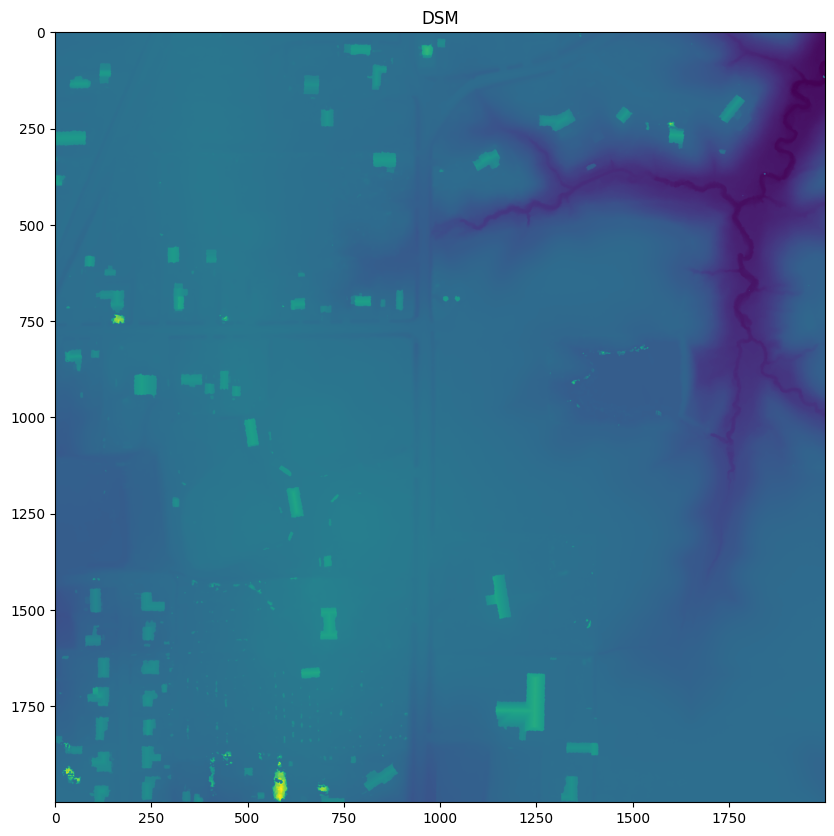

Success in Creating DSM


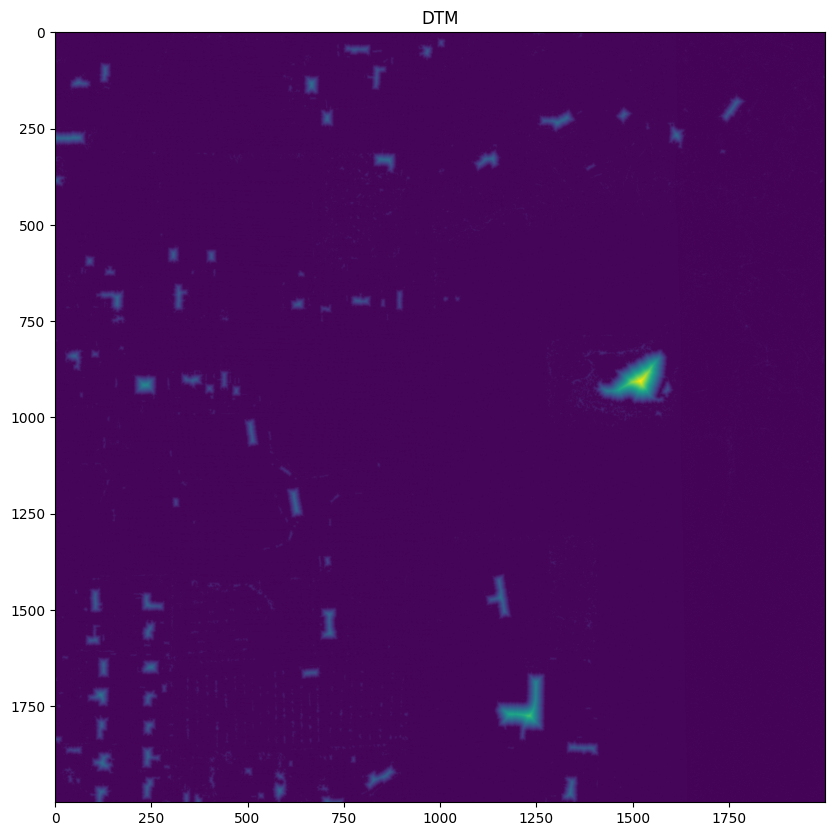

Success in Creating DTM


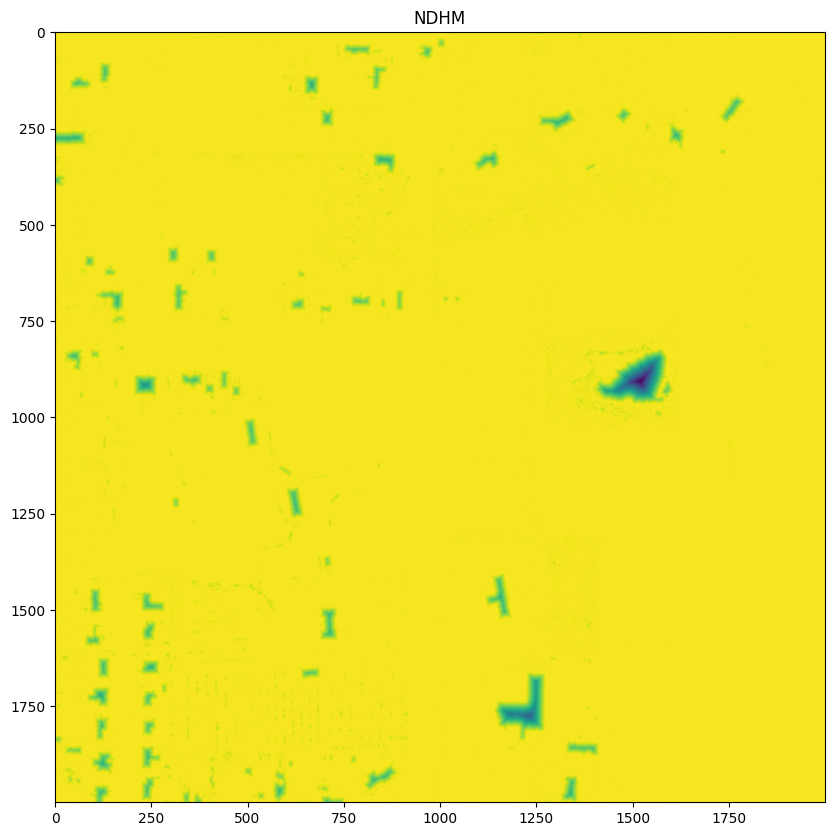

Success in Creating NDHM


In [2]:

# Define input parameters

# Define contour filtering parameters (You dont need to change this ones)
min_size = 35
max_size = 5000
squareness_threshold = 0.3
width_threshold = 3
height_threshold = 3
CloseKernel_size = 15

constant = 3.6  # Adaptive threshold constant
block_size = 91  # Adaptive threshold block size
kernel_size = 5  # Morphological open kernel size
tri_threshold = 45  # Terrain Ruggedness Index threshold
multy = 1200  # Multiplication factor for DSM height enhancement

# Path to the input laz/las data file
# 10
# input_laz = r'./datasets/10-USGS_LPC_IL_GrnMacMont_2017_2403_1011_LAS_2018.laz'  
# 9
input_laz=r'./datasets/9-USGS_LPC_IL_8County_2020_A20_1035_8430.laz'
# 4
# input_laz= r'./datasets/4-USGS_LPC_CT_Statewide_C16_250890_se.laz'
# 11
# input_laz= r'./datasets/11-USGS_LPC_IL_HicksDome_FluorsparDistrict_2019_D19_2339_5650.laz'
# 0 
# input_laz= r'./datasets/0-USGS_LPC_AL_AGIO_B1_2016_16S_EB_2340_LAS_2018.laz'
# 6
# input_laz=r'./datasets/6-USGS_LPC_GA_SW_Georgia_22_County_Lidar_2017_B17_GAW_20750320.laz'
# 13
# input_laz=r'./datasets/13-USGS_LPC_KY_Eastern_2019_A19_e1174n1677.laz'
# 16
# input_laz= r'./datasets/16-USGS_LPC_MI_FEMA_2019_C19_845492.laz'
# 7
# input_laz=r'./datasets/7-USGS_LPC_GA_Statewide_2018_B18_DRRA_e1076n1315.laz'
# 8 
# input_laz=r'./datasets/8-USGS_LPC_IA_NorthCentral_2020_D20_w4350n4631.laz'
 
 # Path to  Ground Truth
# 10
# GroundTruth = r'./datasets/ground-truth/10-USGS_LPC_IL_GrnMacMont_2017_2403_1011_LAS_2018_gt_buildings.geojson';  epsg_code= 6457; output_number=10
# 9
GroundTruth = r'./datasets/ground-truth/9-USGS_LPC_IL_8County_2020_A20_1035_8430_gt_buildings.geojson';  epsg_code=6455 ; output_number= 9
# 4
# GroundTruth= r'./datasets/ground-truth/4-USGS_LPC_CT_Statewide_C16_250890_se_gt_buildings.geojson' ; epsg_code= 6434; output_number=4
# 11
# GroundTruth= r'./datasets/ground-truth/11-USGS_LPC_IL_HicksDome_FluorsparDistrict_2019_D19_2339_5650_gt_buildings.geojson'; # epsg_code = 6457; output_number= 1
# 0
# GroundTruth= r'./datasets/ground-truth/0-USGS_LPC_AL_AGIO_B1_2016_16S_EB_2340_LAS_2018_gt_buildings.geojson';  epsg_code= 6345 ; output_number=0
# 6
# GroundTruth=r'./datasets/ground-truth/6-USGS_LPC_GA_SW_Georgia_22_County_Lidar_2017_B17_GAW_20750320_gt_buildings.geojson';  epsg_code= 6447 ; output_number= 6
#13
# GroundTruth= r'./datasets/ground-truth/13-USGS_LPC_KY_Eastern_2019_A19_e1174n1677_gt_buildings.geojson'; epsg_code= 6350; output_number= 13 
#16
# GroundTruth=r'./datasets/ground-truth/16-USGS_LPC_MI_FEMA_2019_C19_845492_gt_buildings.geojson'; epsg_code= 6494 ; output_number= 16
#7
# GroundTruth= r'./datasets/ground-truth/7-USGS_LPC_GA_Statewide_2018_B18_DRRA_e1076n1315_gt_buildings.geojson' ; epsg_code= 6350 ; output_number = 7
# 8 
# GroundTruth= r'./datasets/ground-truth/8-USGS_LPC_IA_NorthCentral_2020_D20_w4350n4631_gt_buildings.geojson'  ; epsg_code=6344 ; output_number=8
# epsg_code = 6457  # EPSG code of the input laz data
intermethod = 'nearest'  # Interpolation method ('cubic', 'nearest', or 'linear')

#EPSG code for file 8

# epsg_code= 6344
# You can change this paramets to see how it effects the building maps
# output_number = 8 # use this variable so you can change name of every output you get automaticly


print("cwd",os.getcwd())

# Generate DSM and DTM
generate_dsm(input_laz, epsg_code, intermethod)
generate_dtm(input_laz, epsg_code, intermethod, multy)

# Generate NDHM
generate_ndhm('dtm.tif', 'dsm.tif')

In [3]:
import os




def calc_iou(gdf_groundtruth, gdf_predict):
    """Calculates intersection over union (iou) score.

    Args:
      gdf_groundtruth: Groundtruth GeoDataFrame of polygons.
      gdf_predict: Predicted GeoDataFrame of polygons.

    Returns:
      Intersection Over Union (IOU) Score.

    """
    
    intersect = gdf_groundtruth.dissolve().intersection(gdf_predict.dissolve()).area
    union = gdf_groundtruth.dissolve().union(gdf_predict.dissolve()).area
    iou = intersect / union
    
    return iou[0]

def calc_metrics(groundtruth_file, predict_file):
    """Reads geojson files, and calculates IOU.

    Args:
      groundtruth_file: Geojson file for groundtruth.
      predict_file: Geojson file for predictions.

    Returns:
      Intersection over union (IOU) score with punishment.
    """
    
    gdf_groundtruth = gpd.read_file(groundtruth_file)
    gdf_predict = gpd.read_file(predict_file)
    
    # Validate the CRS
    assert gdf_predict.crs==3857, (
        f'All geometries must be in EPSG:3857 Coordinate Reference System.')
    assert gdf_groundtruth.crs==3857, (
        f'All geometries must be in EPSG:3857 Coordinate Reference System.')
    
    # Validate the geometry column
    assert "geometry" in gdf_predict.columns, (
        f'Missing geometry column.')
    assert "geometry" in gdf_groundtruth.columns, (
        f'Missing geometry column.')
    
    iou = calc_iou(gdf_groundtruth, gdf_predict)
    # Punish if more polygon provided 
    if len(gdf_groundtruth)<len(gdf_predict):
        iou = iou * (len(gdf_groundtruth)/len(gdf_predict))
    
    return iou
    

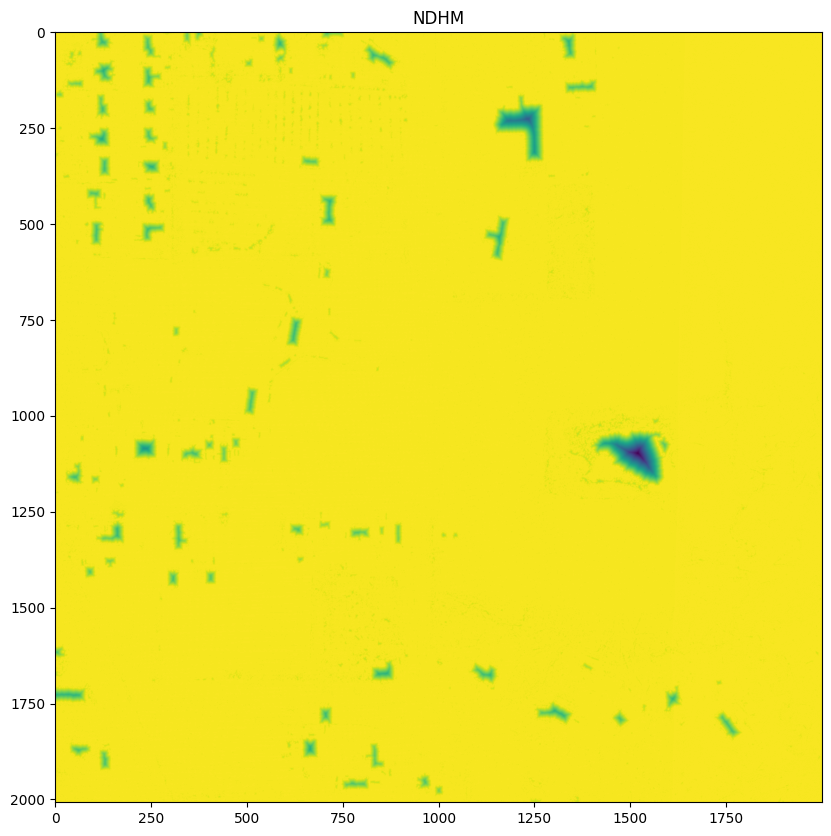

profile {'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 2000, 'height': 2008, 'count': 1, 'crs': 'EPSG:3857', 'transform': Affine(0.3924019048468253, 0.0, -9813348.346614616,
       0.0, -0.3924019048468253, 4719817.9558201805), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}


In [4]:

img, profile = read_geotiff('ndhm.tif')

# Visualize the result
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.title("NDHM")
plt.axis("on")
plt.show()

print('profile',profile)

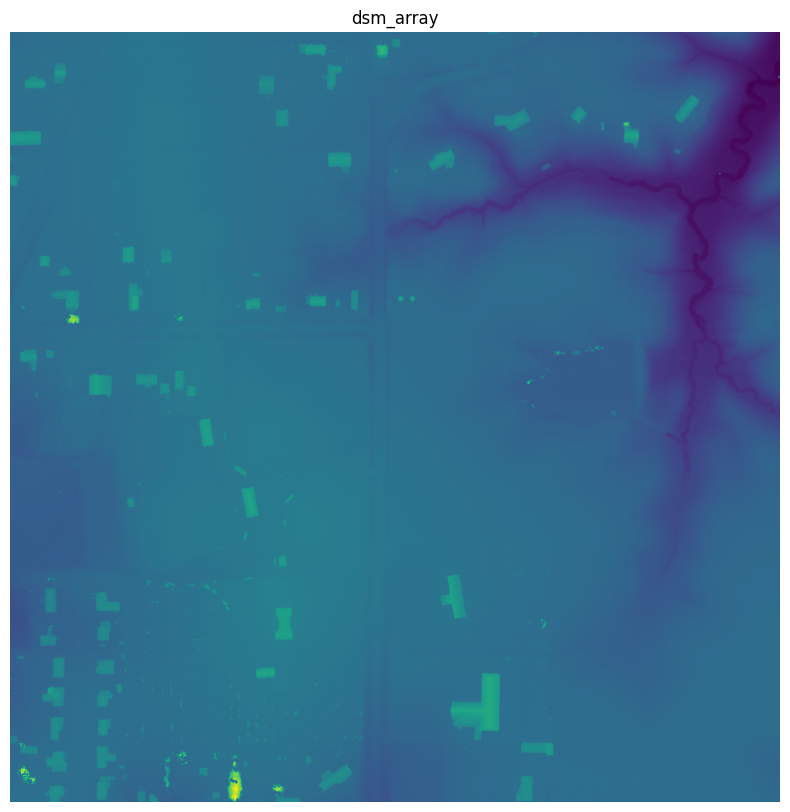

In [5]:
import rasterio

DSM_transform('dsm.tif')  #    Transform the DSM to the target CRS (EPSG:3857).


# Path to your DSM TIFF file
dsm_tif_path = 'dsm.tif'

# Open the DSM TIFF file using rasterio
with rasterio.open(dsm_tif_path) as dsm_dataset:
    # Get the affine transform for the dataset
    transform = dsm_dataset.transform
    # Get the width and height of the dataset
    width = dsm_dataset.width
    height = dsm_dataset.height
    # Get the bounding box of the dataset
    bounds = dsm_dataset.bounds
    # Get the coordinate reference system (CRS) of the dataset
    crs = dsm_dataset.crs
    # Read the first band (DSM data is typically in the first band)
    dsm_array = dsm_dataset.read(1)

# Visualize the result
plt.figure(figsize=(10, 10))
plt.imshow(dsm_array)
plt.title("dsm_array")
plt.axis("off")
plt.show()


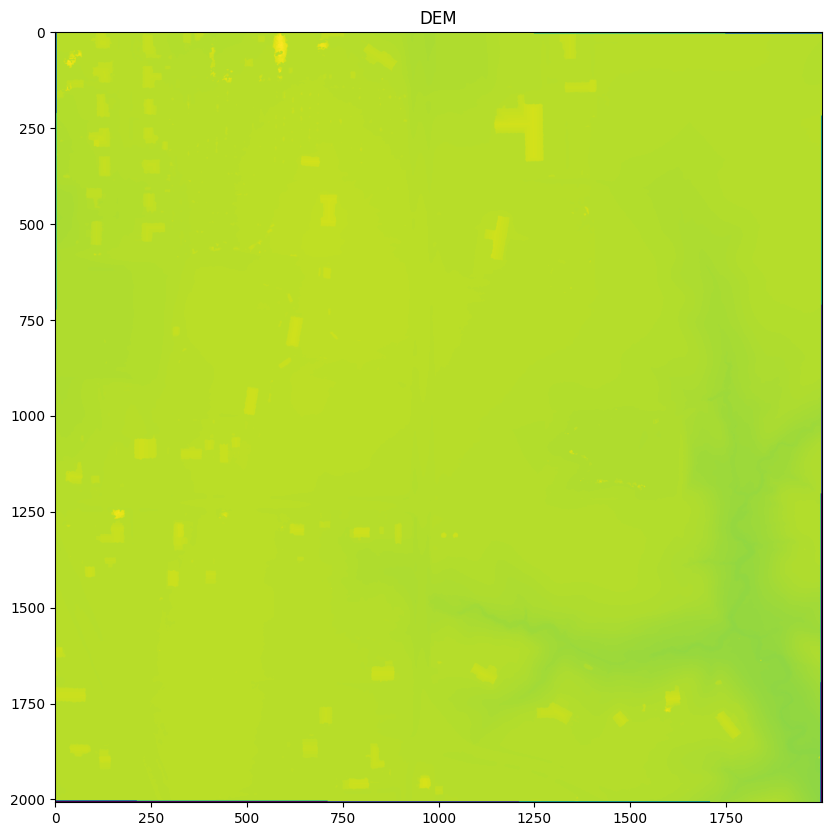

In [6]:
dem, _ = read_geotiff('dsm3857.tif')

# Visualize the result
plt.figure(figsize=(10, 10))
plt.imshow(dem)
plt.title("DEM")
plt.axis("on")
plt.show()

In [7]:
img_8bit = to_8bit(img)
#    Convert an image to 8-bit color depth.
print(img)
print(img_8bit)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[251 251 251 ... 251 251 251]
 [251 251 251 ... 251 251 251]
 [251 251 251 ... 251 251 251]
 ...
 [251 251 251 ... 251 251 251]
 [251 251 251 ... 251 251 251]
 [251 251 251 ... 251 251 251]]


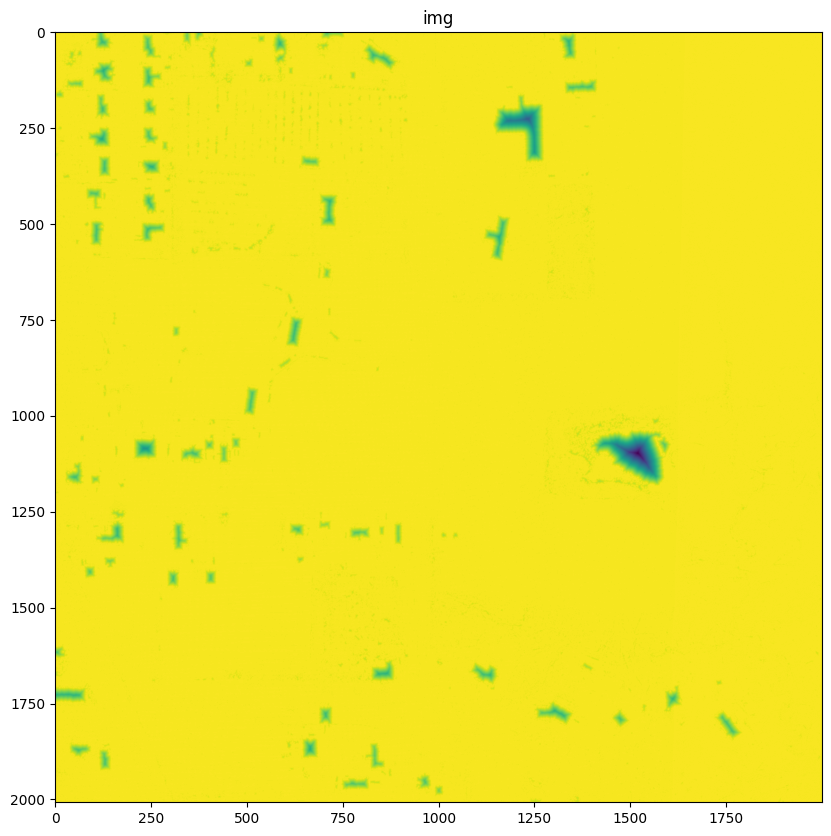

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


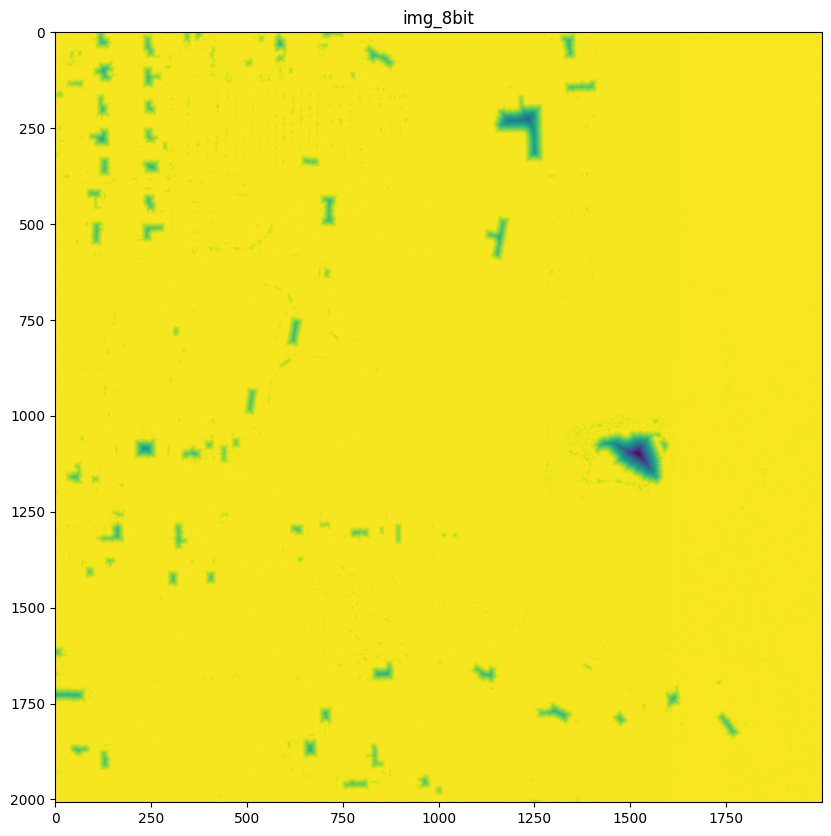

[[251 251 251 ... 251 251 251]
 [251 251 251 ... 251 251 251]
 [251 251 251 ... 251 251 251]
 ...
 [251 251 251 ... 251 251 251]
 [251 251 251 ... 251 251 251]
 [251 251 251 ... 251 251 251]]


In [8]:
# Visualize the result

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.title("img")
plt.axis("on")
plt.show()
print(img)



plt.figure(figsize=(10, 10))
plt.imshow(img_8bit)
plt.title("img_8bit")
plt.axis("on")
plt.show()
print(img_8bit)

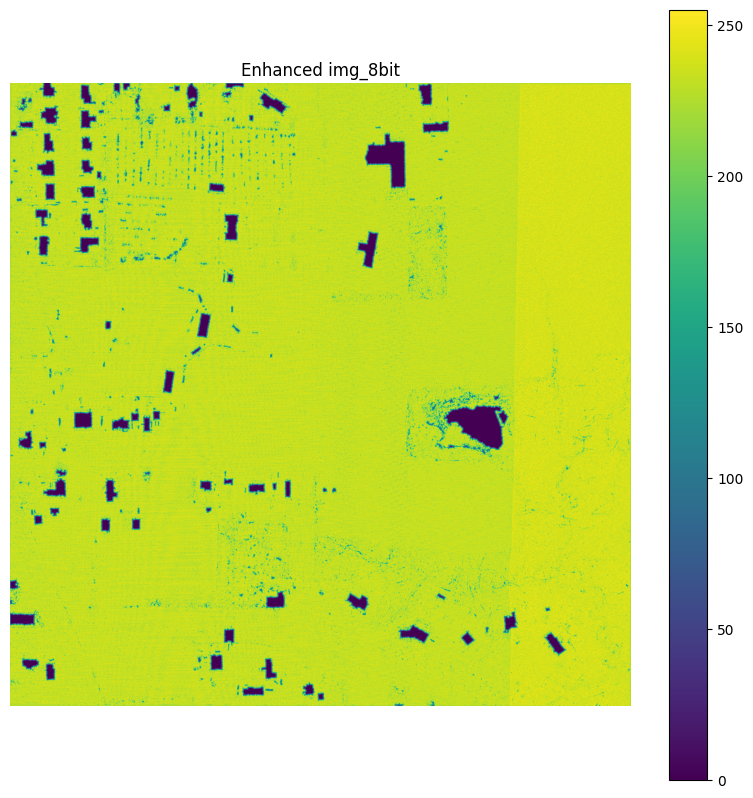

In [9]:
from skimage import exposure


# Assuming 'img_8bit' is already loaded as an 8-bit numpy array from the previous step
# First, let's apply a contrast stretching to the image data
p2, p98 = np.percentile(img_8bit, (2, 98))
img_rescaled = exposure.rescale_intensity(img_8bit, in_range=(p2, p98))

# Now let's choose a colormap and display the image
plt.figure(figsize=(10, 10))
plt.imshow(img_rescaled, cmap='viridis')  # or any other colormap like 'terrain', 'gray', etc.
plt.colorbar()  # Optionally add a colorbar to see the mapping of intensity values
plt.title("Enhanced img_8bit")
plt.axis('off')  # Turn off the axis
plt.show()


kernel size 5


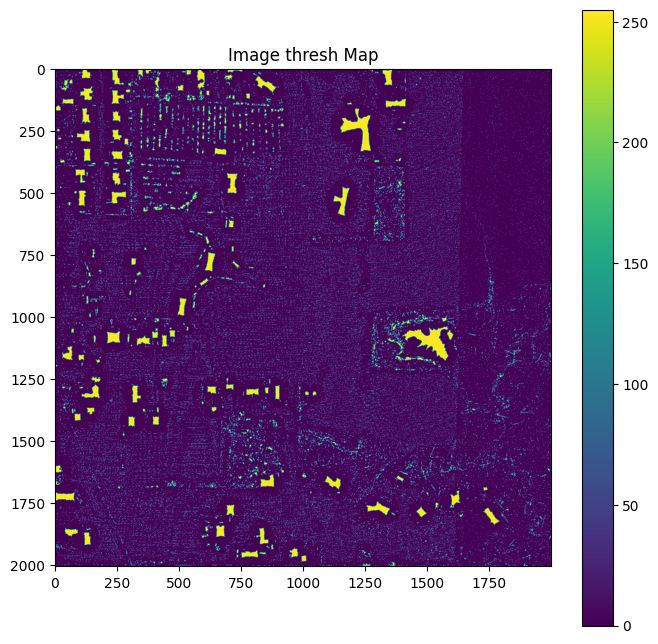

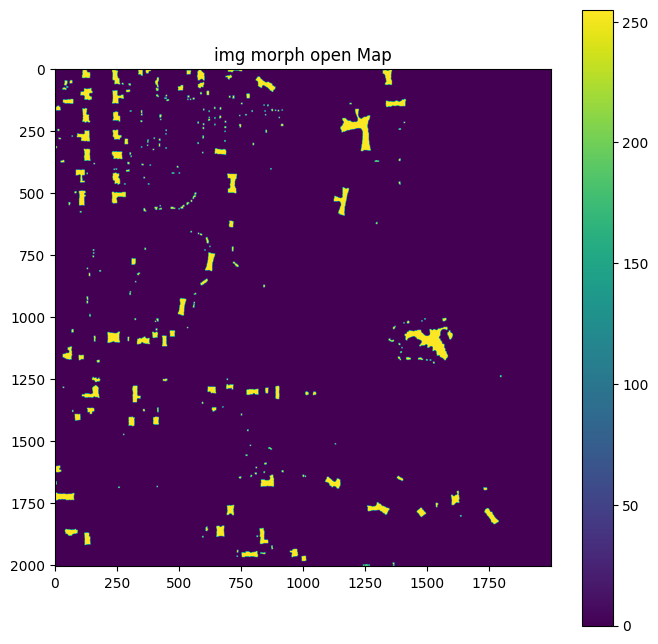

In [10]:
img_thresh = threshold(img_8bit, block_size, constant)   #    Apply an adaptive threshold to an image to separate objects from the background.


plt.figure(figsize=(8,8), dpi=100)
plt.imshow(img_thresh)
plt.title('Image thresh Map')
plt.colorbar()

print ('kernel size', kernel_size)
kernel_size =5
img_open = morph_open(img_thresh, kernel_size) #    Apply a morphological opening to an image to remove small objects.


plt.figure(figsize=(8,8), dpi=100)
plt.imshow(img_open)
plt.title('img morph open Map')
plt.colorbar()


Step 1: Breakline-map delineation done
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


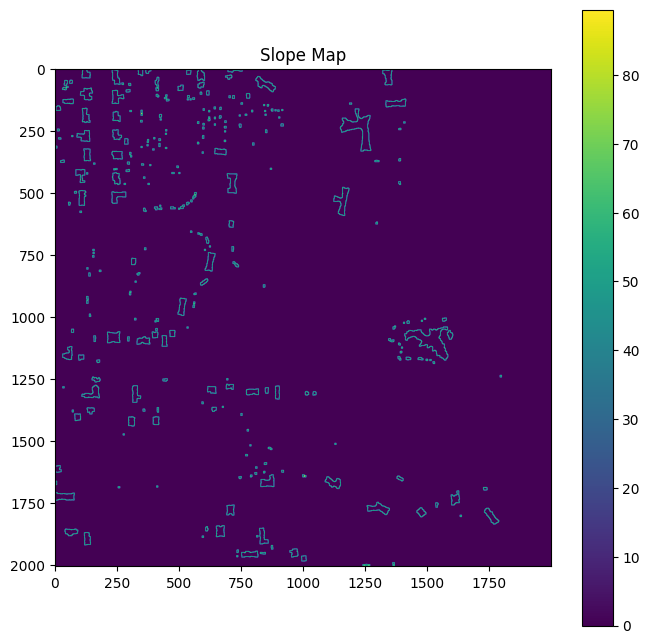

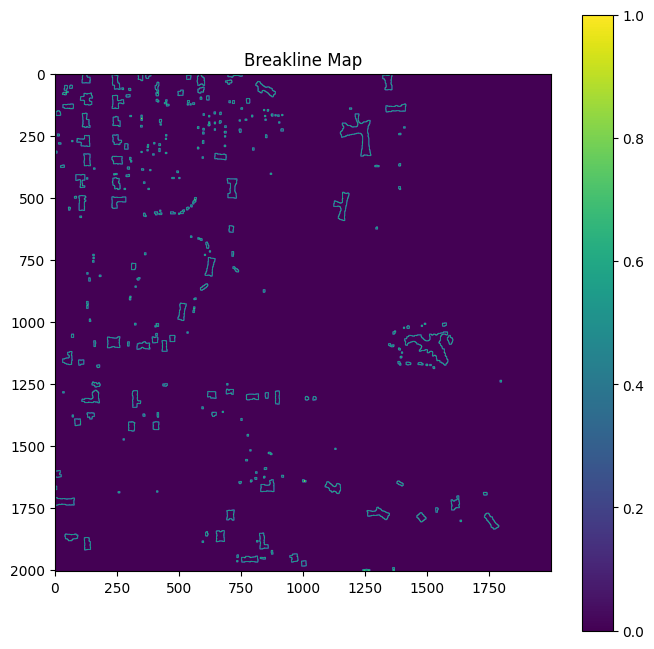

In [11]:
from scipy.signal import convolve2d as conv2

def sobel_filter(img):
    Gx = np.array([[1.0, 0.0, -1.0], [2.0, 0.0, -2.0], [1.0, 0.0, -1.0]])
    Gy = np.array([[1.0, 2.0, 1.0], [0.0, 0.0, 0.0], [-1.0, -2.0, -1.0]])
    gx = conv2(img, Gx, boundary='symm', mode='same')
    gy = conv2(img, Gy, boundary='symm', mode='same')
    sobel_filtered_image = np.sqrt(gx ** 2 + gy ** 2)
    return sobel_filtered_image
# Calculate the slope using sobel filter
target_resolution=1
slope_threshold = 45


sobel_image = sobel_filter(img_open)
slope_map = np.arctan(sobel_image / (10 * target_resolution)) * (180 / np.pi)

plt.figure(figsize=(8,8), dpi=100)
plt.imshow(slope_map)
plt.title('Slope Map')
plt.colorbar()


breakline_map = slope_map >= slope_threshold  # Thresholding the slope


print("Step 1: Breakline-map delineation done")

plt.figure(figsize=(8,8), dpi=100)
plt.imshow(breakline_map)
plt.title('Breakline Map')
plt.colorbar()

print(breakline_map)


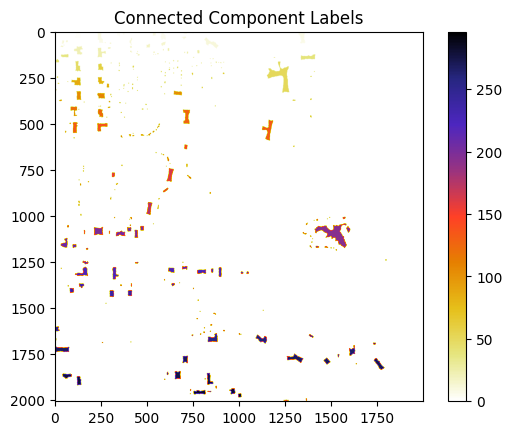

[[0 0 0 ... 0 0 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 0 0 ... 0 0 0]]


In [12]:
import numpy as np
# Invert the breakline map and set boundaries to zero
temp = np.uint8(1 - breakline_map)
temp[:, 0] = 0
temp[0, :] = 0
temp[-1, :] = 0
temp[:, -1] = 0

# Label connected components in the breakline map
number_of_labels, label_map, stats, centroids = cv2.connectedComponentsWithStats(temp, connectivity = 8)
stats_T = np.transpose(stats)
area_stat = stats_T[4]
import matplotlib.pyplot as plt

# Visualize the label_map
plt.imshow(label_map, cmap='CMRmap_r')  # You can choose any colormap you prefer
plt.colorbar()
plt.title('Connected Component Labels')
plt.show()

print(label_map)


In [13]:


# Create output folders for each step if they don't exist
output_base_dir = 'new-output'  # Change this to your desired output base directory
os.makedirs(output_base_dir, exist_ok=True)

# Function to write files to the appropriate folder
def write_output(filename, data, profile, folder_name):
    output_folder = os.path.join(output_base_dir, folder_name)
    os.makedirs(output_folder, exist_ok=True)
    file_path = os.path.join(output_folder, filename)
    write_geotiff(file_path, data, profile)
    building_footprints_to_geojson(file_path, file_path.replace('.tif', '.geojson'))



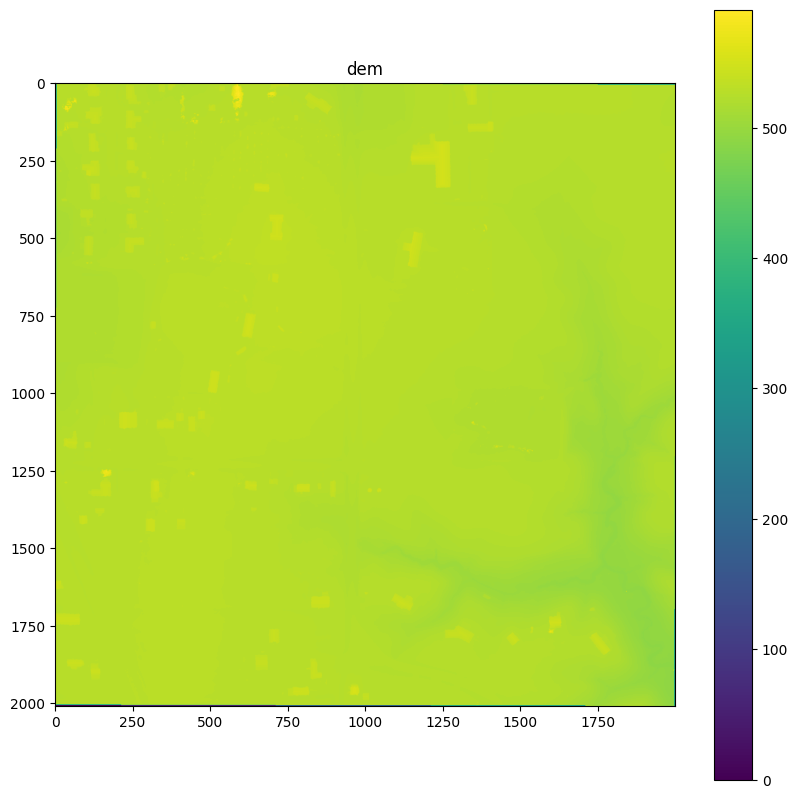

breaklinemap shape (2008, 2000)
dem shape (2008, 2000)


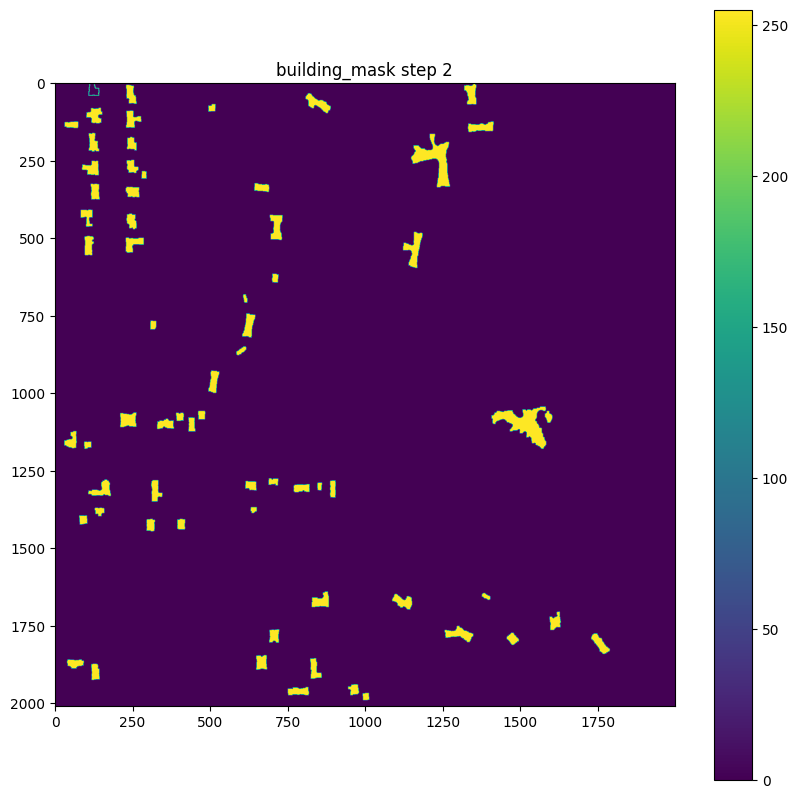

In [60]:
# parameter for other 
# height_threshold=2.5
# max_size= 7000
# tri_threshold=6
# min_size=100

# parameter for other 9
height_threshold=2.5
max_size= 5000
tri_threshold=6
min_size=50

# parameter for 16

# height_threshold=3
# max_size= 10000
# tri_threshold=6
# min_size=150


# #for  dataset 13
# height_threshold=1.5
# tri_threshold=5
# max_size= 7000
# min_size=30


#parameter used for dataset 8
# height_threshold=3.5
# tri_threshold=7
# max_size= 10000
# min_size=200


# #parameter used for dataset 0
# height_threshold=2.5
# tri_threshold=4
# max_size= 7000 #smaller maz
# min_size=50


# # #parameter used for dataset 7
# height_threshold=3.5
# tri_threshold=20
# max_size= 400 #smaller maz
# min_size=250

dem, _ = read_geotiff('dsm3857.tif')
plt.figure(figsize=(10, 10))
plt.imshow(dem)
plt.title("dem")
plt.colorbar()
plt.axis("on")
plt.show()
print('breaklinemap shape', breakline_map.shape)
print('dem shape', dem.shape)

building_mask2 = filter_contours(breakline_map, dem, profile, min_size, max_size, squareness_threshold, width_threshold, height_threshold, tri_threshold)
'''
    """
    Filter out contours that do not meet certain criteria and create a binary mask of the remaining objects.

    Args:
        image: The image data with small objects removed.
        dem: The Digital Elevation Model data.
        profile: A dictionary with metadata about the image.
        min_size (int): The minimum size of objects to keep.
        max_size (int): The maximum size of objects to keep.
        squareness_threshold (float): The minimum squareness of objects to keep (ratio of width to height).
        width_threshold (int): The minimum width of objects to keep.
        height_threshold (int): The minimum height of objects to keep.
        tri_threshold (float): The maximum Terrain Ruggedness Index (TRI) value to keep.

    Returns:
        numpy.ndarray: A binary mask where the objects to keep are white and the rest is black.
'''
plt.figure(figsize=(10, 10))
plt.imshow(building_mask2)
plt.title("building_mask step 2")
plt.colorbar()
plt.axis("on")
plt.show()

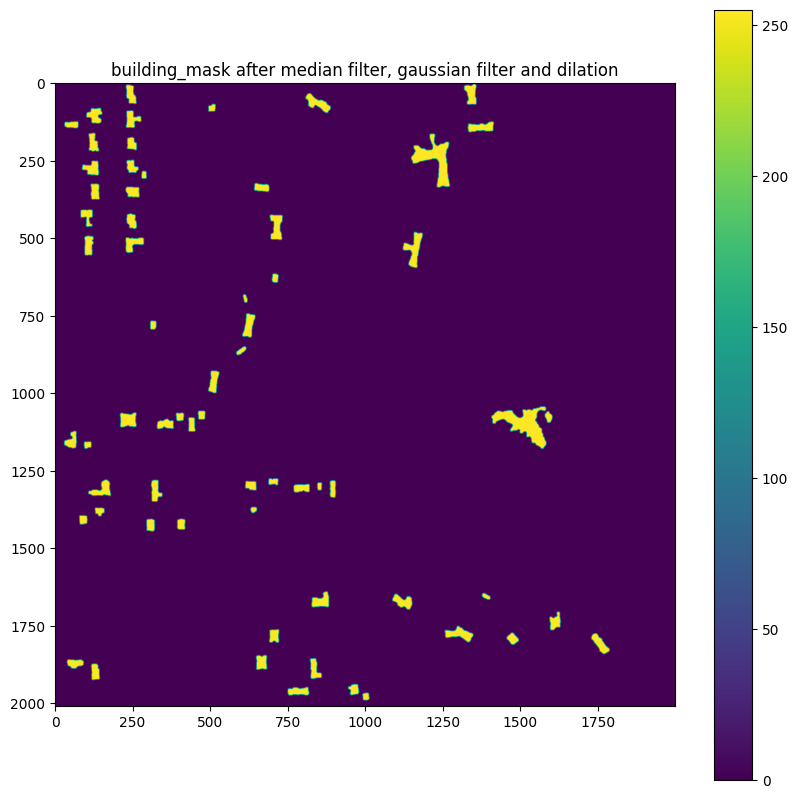

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [61]:
# Apply morphological operations
from scipy.ndimage import median_filter, minimum_filter

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))  # Adjust the size according to your needs
eroded = cv2.erode(building_mask2, kernel, iterations=1)  # Remove thin connections


import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'image' is your binary image loaded as grayscale where buildings are white and the background is black.

# Apply a median filter. Choose the kernel size to be large enough to remove noise but small enough to preserve the details of buildings.
median_filtered_image = median_filter(eroded, 5)  # ksize is the aperture linear size; it must be odd and greater than 1, like 3, 5, 7...
# median_filtered_image = median_filter(median_filtered_image, 7)  # ksize is the aperture linear size; it must be odd and greater than 1, like 3, 5, 7...
# median_filtered_image = median_filter(median_filtered_image, 5)  # ksize is the aperture linear size; it must be odd and greater than 1, like 3, 5, 7...
# median_filtered_image = median_filter(median_filtered_image, 5)  # ksize is the aperture linear size; it must be odd and greater than 1, like 3, 5, 7...



blurred_image = cv2.GaussianBlur(median_filtered_image, (5, 5), 0)


dilated = cv2.dilate(blurred_image, kernel, iterations=1)  # Restore building size

plt.figure(figsize=(10, 10))
plt.imshow(dilated)
plt.title("building_mask after median filter, gaussian filter and dilation" )
plt.colorbar()
plt.axis("on")
plt.show()
print(dilated)

In [62]:
write_output('dilated_final_mask' + str(output_number) + '.tif',dilated , profile, 'S3_MorphClose')


Output GeoJSON is ready


In [63]:
print('./new-output/S3_MorphClose/dilated_final_mask'+ str(output_number) + '.geojson')

./new-output/S3_MorphClose/dilated_final_mask9.geojson


    value                                           geometry
0       0  POLYGON ((-9813258.487 4719816.386, -9813253.3...
1       0  POLYGON ((-9812820.566 4719817.563, -9812816.2...
2       0  POLYGON ((-9813028.539 4719805.791, -9813025.0...
3       0  POLYGON ((-9813150.184 4719792.057, -9813145.4...
4       0  POLYGON ((-9813302.828 4719786.956, -9813299.2...
..    ...                                                ...
59      0  POLYGON ((-9813021.868 4719091.227, -9813018.3...
60      0  POLYGON ((-9813301.258 4719084.164, -9813294.9...
61      0  POLYGON ((-9813032.071 4719054.734, -9813028.1...
62      0  POLYGON ((-9812972.033 4719058.266, -9812965.3...
63      0  POLYGON ((-9812957.122 4719047.278, -9812951.6...

[64 rows x 2 columns]
                                             geometry
0   MULTIPOLYGON (((-9813311.644 4719813.394, -981...
1   MULTIPOLYGON (((-9813258.750 4719816.707, -981...
2   MULTIPOLYGON (((-9813217.808 4719806.413, -981...
3   MULTIPOLYGON (((-9813206.

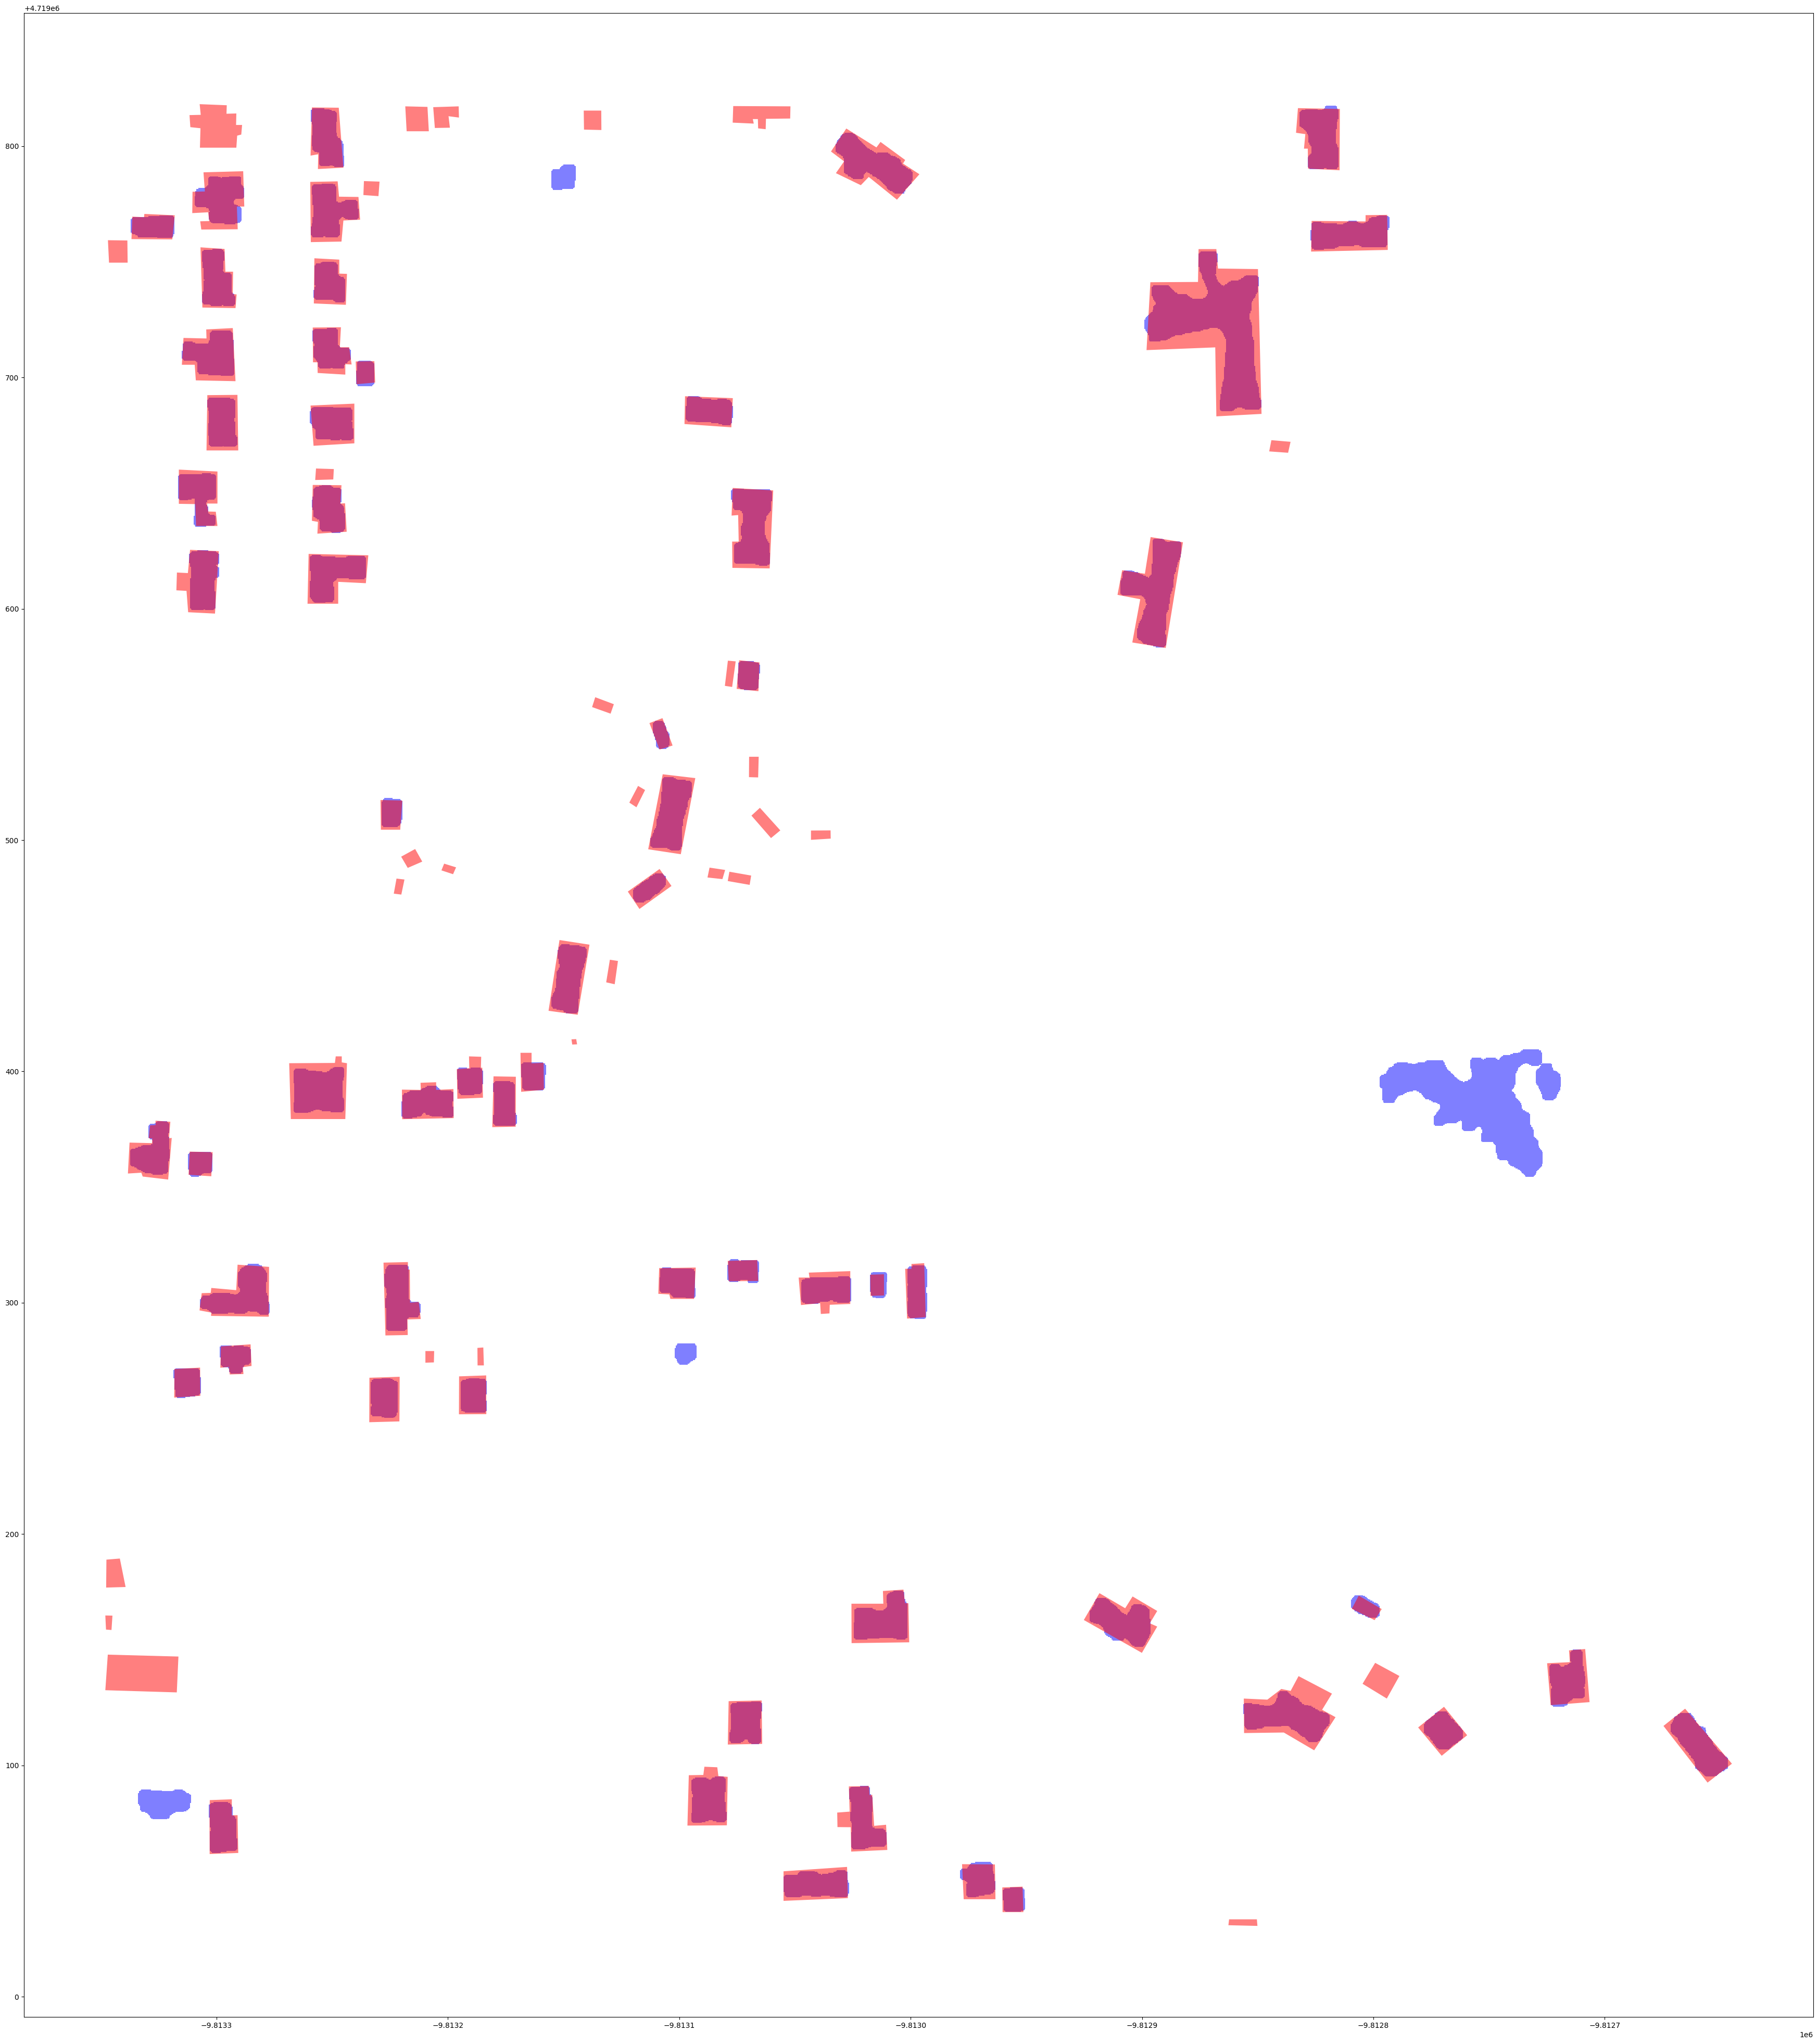

In [64]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the ground truth GeoJSON file
ground_truth = gpd.read_file(GroundTruth)
detected_mask = gpd.read_file('./new-output/S3_MorphClose/dilated_final_mask'+ str(output_number) + '.geojson')

# Plot the detected mask and ground truth GeoJSON
fig, ax = plt.subplots(figsize=(50,50))

# Plot the detected mask
detected_mask.plot(ax=ax, color='blue', alpha=0.5)
print(detected_mask)
# Plot the ground truth GeoJSON
ground_truth.plot(ax=ax, color='red', alpha=0.5)
print(ground_truth)
plt.show()


Ground Truth bounds: [-9813348.03086948  4719030.63661844 -9812645.05783107  4719818.1273512 ]
Detected Mask bounds: [-9813337.35936128  4719036.68362763 -9812646.73200875  4719817.56341828]
Invalid geometries in ground truth: False
Invalid geometries in detected mask: False


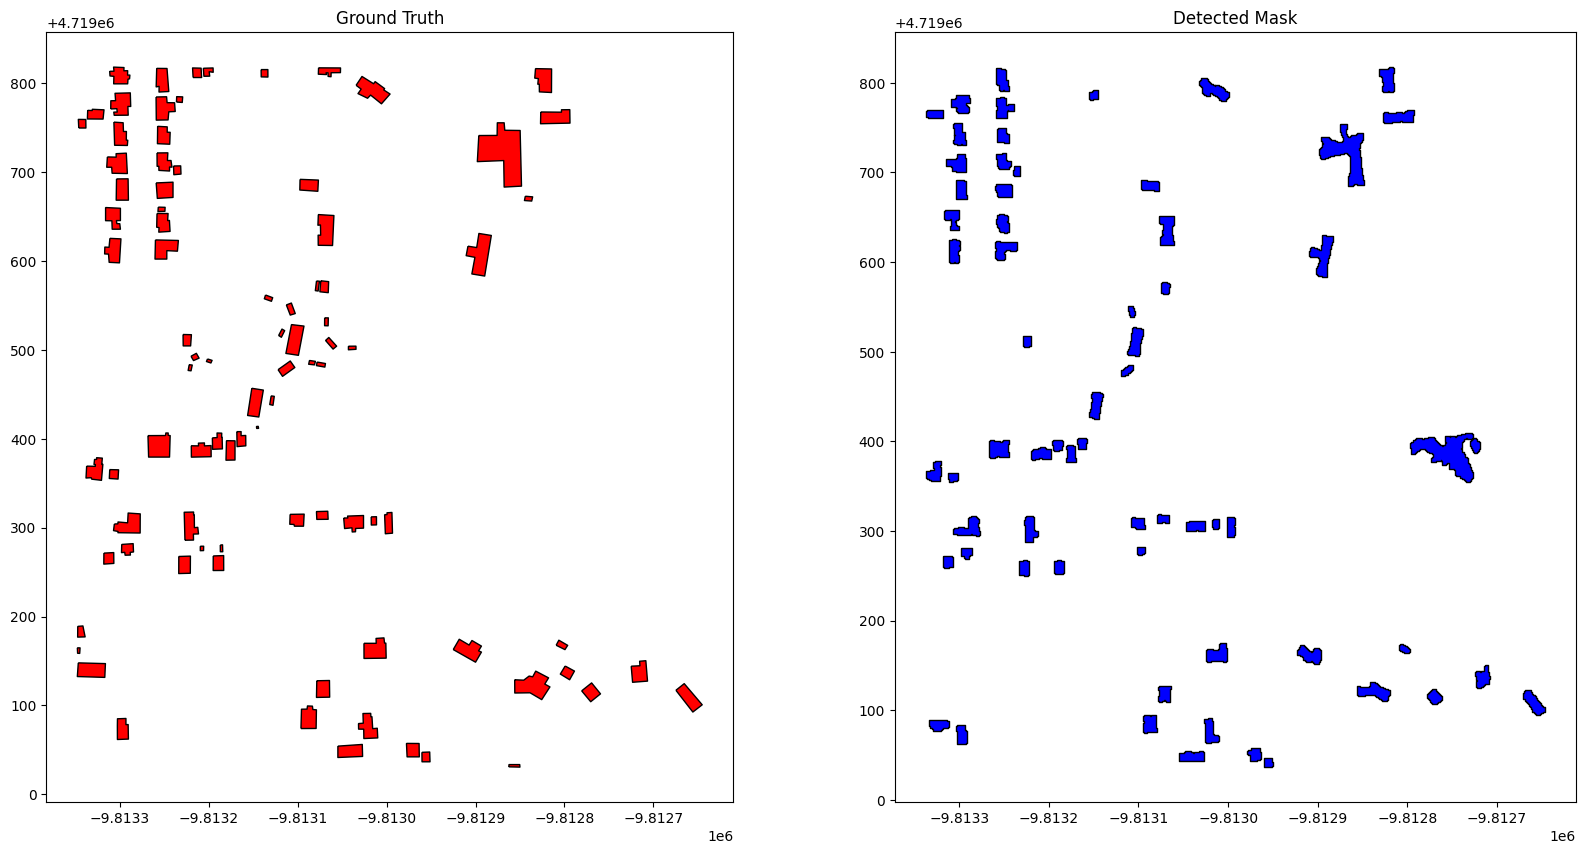

In [65]:
# Check if bounding boxes overlap
gt_bounds = ground_truth.total_bounds
dm_bounds = detected_mask.total_bounds
print(f"Ground Truth bounds: {gt_bounds}")
print(f"Detected Mask bounds: {dm_bounds}")

# Validate geometries
print("Invalid geometries in ground truth:", ground_truth.is_valid.sum() != len(ground_truth))
print("Invalid geometries in detected mask:", detected_mask.is_valid.sum() != len(detected_mask))

# Plot both GeoDataFrames to visually check for overlaps
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

ground_truth.plot(ax=axes[0], color='red', edgecolor='black')
axes[0].set_title('Ground Truth')

detected_mask.plot(ax=axes[1], color='blue', edgecolor='black')
axes[1].set_title('Detected Mask')

plt.show()
try:
    intersection = gpd.overlay(ground_truth, detected_mask, how='intersection')
except Exception as e:
    print(f"An error occurred during intersection: {e}")

C:\Users\Sarvi\AppData\Local\Temp\ipykernel_32944\793352038.py:21: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Ground Truth CRS: EPSG:3857
Detected Mask CRS: EPSG:3857


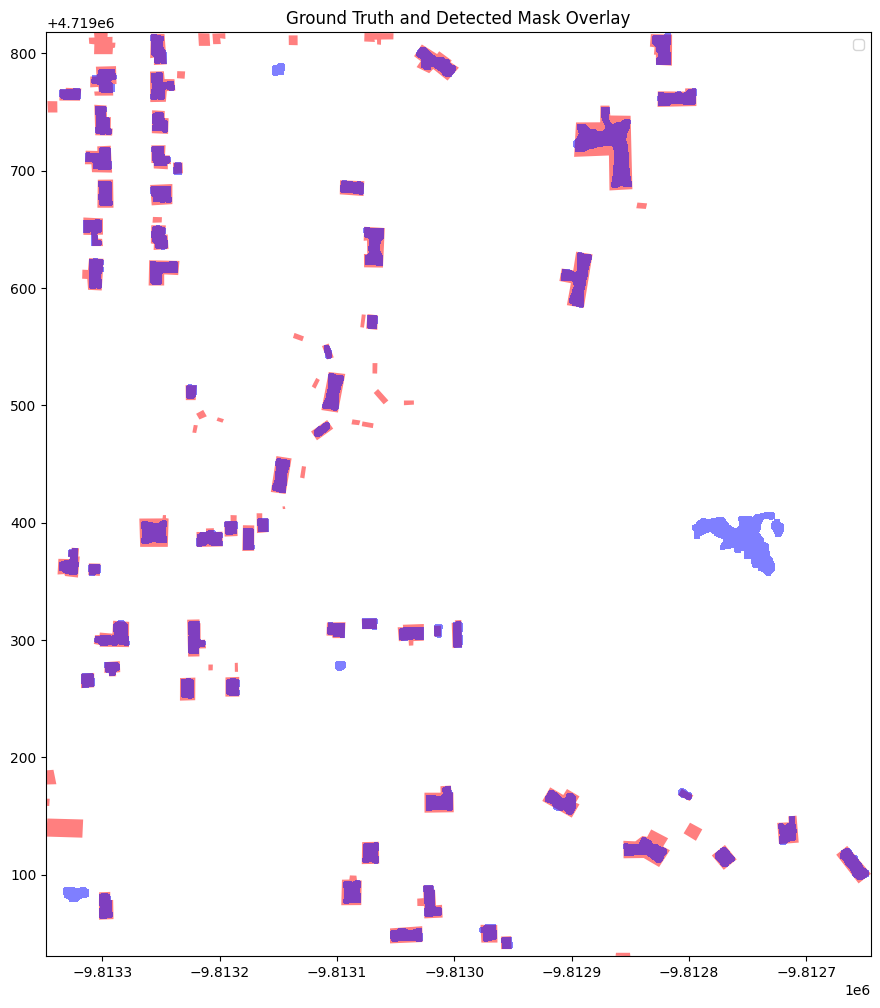

In [66]:
print("Ground Truth CRS:", ground_truth.crs)
print("Detected Mask CRS:", detected_mask.crs)
if ground_truth.crs != detected_mask.crs:
    detected_mask = detected_mask.to_crs(ground_truth.crs)
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Use the bounds from the ground truth for setting axis limits
xmin, ymin, xmax, ymax = ground_truth.total_bounds

# Plot the ground truth
ground_truth.plot(ax=ax, color='red', alpha=0.5, label='Ground Truth')

# Plot the detected mask
detected_mask.plot(ax=ax, color='blue', alpha=0.5, label='Detected Mask')

# Set the same axis limits for both plots
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

# Add legend and title
ax.legend()
plt.title('Ground Truth and Detected Mask Overlay')

plt.show()


In [67]:
notri_IOU = calc_metrics(GroundTruth,'./new-output/S3_MorphClose/dilated_final_mask'+ str(output_number) + '.geojson')





In [68]:
print(round(notri_IOU, 2))



0.64


In [69]:
#11 and 10 works well
# 16, 0, 9,7,6, 0,8  and 13 not good
# 4 error in finding the ndhm because dsm and dtm have different shape
#